In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
en_stopwords = set(stopwords.words('english')) 
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from rouge import Rouge
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Load dataset
data = pd.read_csv("Reviews.csv")
# Drop Duplicates and NA values
data.drop_duplicates(subset=['Text'], inplace=True)  # dropping duplicates
data.dropna(axis=0, inplace=True)  # dropping na
data = data.reset_index(drop=True)
columns_to_keep = ["Text", "Summary"]
data = data[columns_to_keep]
data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [6]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                       "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                       "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                       "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                       "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                       "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                       "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                       "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                       "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                       "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                       "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                       "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                       "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                       "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                       "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                       "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                       "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                       "you're": "you are", "you've": "you have"
                      }

def preprocess_text(text):
    ''' clean text column in dataset'''
    # lowercase words
    clean_text = text.lower() 
    # remove HTML tags
    clean_text = BeautifulSoup(clean_text, "lxml").text 
    clean_text = re.sub(r'\([^)]*\)', '', clean_text)
    # remove quotes
    clean_text = re.sub('"', '', clean_text) 
    # the dictionary that we will use for expanding the contractions
    clean_text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in clean_text.split(" ")]) 
    # match all strings that contain a non-letter
    clean_text = re.sub('[^a-zA-Z0-9\s]', '', clean_text) 
    tokens = [w for w in clean_text.split() if not w in en_stopwords]
     # remove the whitespaces or specific characters from the string at the beginning and end of the string
    clean_text = (" ".join(tokens)).strip()
    return clean_text

data["Raw_Text"] = data["Text"].copy()
data['Text'] = data['Text'].apply(preprocess_text)
data.head()

,Text,Summary,Raw_Text
0,bought several vitality canned dog food produc...,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,product arrived labeled jumbo salted peanutsth...,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,confection around centuries light pillowy citr...,"""Delight"" says it all",This is a confection that has been around a fe...
3,looking secret ingredient robitussin believe f...,Cough Medicine,If you are looking for the secret ingredient i...
4,great taffy great price wide assortment yummy ...,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
# Train-test split
X = data["Text"].tolist()
y = data["Summary"].tolist()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train Size: {len(X_train)}")
print(f"Validation Size: {len(X_val)}")

Train Size: 3987
Validation Size: 997


In [8]:
# Tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocab Size: {vocab_size}")

Vocab Size: 14987


In [9]:
# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [10]:
print(f"Text: {X_train[0]}")
print(f"\nText to Sequence: {X_train_seq[0]}")

Text: im quest try ramen flavors ramen good lunch easy make cheap versital chicken flavor one remember havent long time one flavors sold stores live made recently better remember salty good one americanized flavors recommend adding 2 cups water added bit 1 14 cup perfect 1 14 1 13 1 12 seems perfect amount like eating soup dont pour water add things ramen like meat eggs vegetarian protein frozen veggies make filling meal eat plain dont use seasoning packet add seasonings whatever like great product recommend want easy cheap lunches

Text to Sequence: [1370, 3320, 30, 1434, 46, 1434, 2, 581, 81, 23, 429, 4840, 187, 8, 5, 627, 3862, 149, 24, 5, 46, 568, 180, 509, 40, 388, 25, 627, 310, 2, 5, 6712, 46, 50, 540, 89, 282, 32, 204, 70, 246, 810, 52, 100, 246, 810, 246, 1166, 246, 255, 247, 100, 196, 1, 124, 368, 748, 1053, 32, 75, 201, 1434, 1, 451, 676, 1908, 396, 1084, 811, 23, 768, 341, 38, 332, 748, 19, 749, 628, 75, 2057, 769, 1, 3, 6, 50, 76, 81, 429, 1320]


In [11]:
# Pad sequences
# max_length = 100  
# maximum length of sentences
max_length = max([len(each_text) for each_text in X_train_seq])
print(f"Max Length of the Text: {max_length}")
# Pad sequences with zeros and apply masking
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_padded = tf.keras.preprocessing.sequence.pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')

Max Length of the Text: 443


In [12]:
print(f"Padding: {X_train_padded[0]}")

Padding: [1370 3320   30 1434   46 1434    2  581   81   23  429 4840  187    8
    5  627 3862  149   24    5   46  568  180  509   40  388   25  627
  310    2    5 6712   46   50  540   89  282   32  204   70  246  810
   52  100  246  810  246 1166  246  255  247  100  196    1  124  368
  748 1053   32   75  201 1434    1  451  676 1908  396 1084  811   23
  768  341   38  332  748   19  749  628   75 2057  769    1    3    6
   50   76   81  429 1320    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0   

In [13]:
# Masking for padded tokens
mask = (X_train_padded != 0).astype(float)
mask

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [14]:
# Actor-Critic model
class ActorCritic(tf.keras.Model):
    def __init__(self, num_actions, vocab_size):
        super(ActorCritic, self).__init__()
        # Actor network
        self.actor = tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, 128, input_length=max_length),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
            tf.keras.layers.GlobalMaxPooling1D(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(num_actions, activation='softmax')
        ])
        # Critic network
        self.critic = tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, 128, input_length=max_length),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
            tf.keras.layers.GlobalMaxPooling1D(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1)
        ])

    def call(self, state):
        # Forward pass for actor network
        action_probs = self.actor(state)
        # Forward pass for critic network
        value = self.critic(state)
        return action_probs, value

In [15]:
# Custom loss functions
def actor_loss(action_probs, advantages):
    return -tf.reduce_mean(tf.math.log(action_probs) * advantages)

def critic_loss(value, returns):
    return tf.reduce_mean(tf.square(returns - value))

In [16]:
# Training function
def train_step(actor_critic, states, actions, returns, advantages):
    with tf.GradientTape() as tape:
        # Forward pass
        action_probs, values = actor_critic(states)
        # Calculate actor and critic losses
        actor_loss_val = actor_loss(action_probs, advantages)
        critic_loss_val = critic_loss(values, returns)
        total_loss = actor_loss_val + critic_loss_val
    # Compute gradients
    grads = tape.gradient(total_loss, actor_critic.trainable_variables)
    # Apply gradients
    optimizer.apply_gradients(zip(grads, actor_critic.trainable_variables))
    return total_loss

In [17]:
# Define ROUGE score calculation function
def calculate_rouge(generated_summary, ground_truth_summary):
    if not ground_truth_summary.strip():  # Check if the ground truth summary is empty
        return 0.0  # Return a default value or handle it as appropriate
    rouge = Rouge()
    scores = rouge.get_scores(generated_summary, ground_truth_summary)
    return scores[0]['rouge-1']['f']

In [18]:
def generate_summary(actor_critic, text):
    state = tokenizer.texts_to_sequences([text])
    state = tf.keras.preprocessing.sequence.pad_sequences(state, maxlen=max_length, padding='post')
    action_probs, _ = actor_critic(state)
    action_probs = action_probs[0]  # Extract probabilities from batch
    #print("Action probabilities before softmax:", action_probs)  # Print action_probs for debugging
    # Use softmax with epsilon for numerical stability
    epsilon = 1e-8  # Small epsilon value
    action_probs = tf.nn.softmax(action_probs + epsilon).numpy()
    #print("Action probabilities after softmax:", action_probs)  # Print action_probs after softmax for debugging
    # Choose action index based on probabilities
    action = np.random.choice(len(action_probs), p=action_probs)
    summary = tokenizer.index_word.get(action, 'UNK')  # Get word corresponding to action index
    return summary

In [19]:
# Reward clipping function
def clip_reward(reward):
    return max(min(reward, 1.0), -1.0)

# Compute returns function
def compute_returns(rewards, gamma):
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    return np.array(returns)

In [20]:
# Optimizer
optimizer = tf.keras.optimizers.Adam()
# Example usage
num_actions = 14987  # Number of actions (e.g., size of vocabulary for text summarization)
actor_critic = ActorCritic(num_actions, vocab_size)

In [21]:
# Initialize variables
train_losses = []
val_losses = []

# Training loop
NUM_EPOCHS = 3
gamma = 0.99  # Discount factor
for epoch in range(NUM_EPOCHS):
    epoch_train_losses = []
    epoch_val_losses = []
    
    # Training phase
    for text, summary in zip(X_train, y_train):
        # Preprocess input text
        state = tokenizer.texts_to_sequences([text])
        state = tf.keras.preprocessing.sequence.pad_sequences(state, maxlen=max_length, padding='post')
        
        # Forward pass through critic network to get value estimates
        _, value = actor_critic(state)
        
        # Generate summary using the actor network
        generated_summary = generate_summary(actor_critic, text)
        
        # Calculate reward (ROUGE score)
        reward = calculate_rouge(str(generated_summary), str(summary))
        print(reward)
        
        # Reward clipping
        reward = clip_reward(reward)
        
        # Normalize reward
        reward = (reward - np.mean(reward)) / (np.std(reward) + 1e-8)
        
        # Compute returns and advantages
        returns = compute_returns([reward], gamma)
        advantages = returns - value
        
        # Perform training step
        train_loss = train_step(actor_critic, state, summary, returns, advantages)
        epoch_train_losses.append(train_loss)
    
    # Validation phase
    for text, summary in zip(X_val, y_val):
        # Preprocess input text
        state = tokenizer.texts_to_sequences([text])
        state = tf.keras.preprocessing.sequence.pad_sequences(state, maxlen=max_length, padding='post')
        
        # Forward pass through critic network to get value estimates
        _, value = actor_critic(state)
        
        # Generate summary using the actor network
        generated_summary = generate_summary(actor_critic, text)
        
        # Calculate reward (ROUGE score)
        reward = calculate_rouge(str(generated_summary), str(summary))
        
        # Reward clipping
        reward = clip_reward(reward)
        
        # Normalize reward
        reward = (reward - np.mean(reward)) / (np.std(reward) + 1e-8)
        
        # Compute returns and advantages
        returns = compute_returns([reward], gamma)
        advantages = returns - value
        
        # Compute validation loss (no backpropagation)
        val_loss = compute_loss(actor_critic, state, summary, returns, advantages)
        epoch_val_losses.append(val_loss)
    
    # Compute average losses for the epoch
    avg_train_loss = np.mean(epoch_train_losses)
    avg_val_loss = np.mean(epoch_val_losses)
    
    # Append epoch losses to the list
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    # Print epoch-wise training and validation losses
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}: Train Loss = {avg_train_loss}, Validation Loss = {avg_val_loss}")


Epoch 0, Loss -1.0419723366794642e-05
Epoch 1, Loss -5.079992206447059e-06
Epoch 2, Loss -1.1809473789980984e-06
Epoch 3, Loss -8.734078278394009e-07
Epoch 4, Loss -6.985129630265874e-07


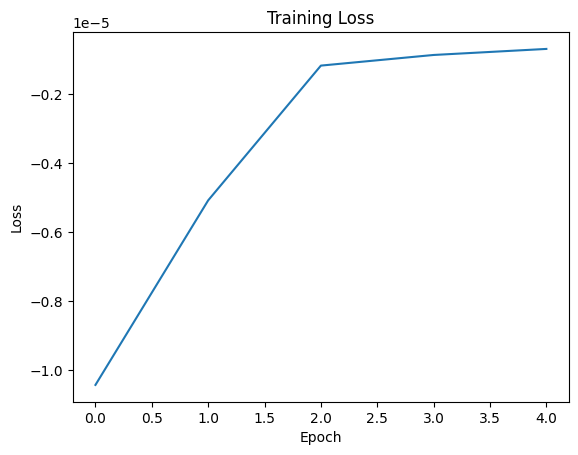

In [22]:
# Plot the loss graph
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()